**Проект: Статистический анализ данных сервиса аренды самокатов GoFast**

## Введение

**Задачи исследования** - проанализировать данные, провести расчеты, проверить гипотезы, которые мешают бизнесу вырасти.

**Цель исследования** - на основе полученных результатов сделать выводы и дать рекомендации по усовершенствованию бизнеса.

**Данные для анализа** – информация о пользователях сервиса аренды самокатов Go Fast, их поездках и подписках.

**Этапы исследования**

Работу над проектом будем проводить в несколько этапов:

* Шаг 1. *Загрузка данных*
* Шаг 2. *Предобработка данных* (данный этап включает в себя также создание вспомогательных столбцов/параметров, которые потребуются для дальнейшего исследования)
* Шаг 3. *Исследовательский анализ данных* (на этом этапе проанализируем некотороые параметры, рассмотрим выбросы: частота встречаемости городов; соотношение пользователей с подпиской и без подписки; возраст пользователей; расстояние, которое пользователь преодолел за одну поездку; продолжительность поездок)
* Шаг 4. *Объединение данных* (создадим общий датафрейм с информацией о пользователях, поездках и подписках, а также создадим отдельные датафреймы c данными о пользователях без подписки и с подпиской)
* Шаг 5. *Подсчёт выручки* (рассчитаем помесячную выручку, которую принёс каждый пользователь)
* Шаг 6. *Проверка гипотез* (проверим гипотезы, сделаем выводы)
* Шаг 7. *Распределения* (проведем исследования, сделаем выводы)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, factorial
from scipy import stats as st
from scipy.stats import binom, poisson, norm

## Шаг 1. Загрузка данных

### Считаем и сохраним данные

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы. 
В основных данных есть информация о пользователях, их поездках и подписках.

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv') # информация о пользователях

In [3]:
data_rides = pd.read_csv('/datasets/rides_go.csv') # информация о поездках

In [4]:
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv') # информация о подписках

### Изучение общей информации

Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

В целях оптимизации кода для получения информации о каждом датафрейме создадим функцию check_df:

In [5]:
def check_df (df):
    display(df.head())  # первые 5 строк
    display(df.info())  # общая информация
    display(df.columns) # наименования столбцов

#### Датафрейм с информацей о пользователях (data_users)

In [6]:
check_df (data_users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

Index(['user_id', 'name', 'age', 'city', 'subscription_type'], dtype='object')

Итак, мы видим, что в данной выборке с информацей о пользователях содержится:

* 1565 строк (количество пользователей)
* 5 столбцов (каждое описание пользователя содержит 5 параметров)

Все наименования столбцов корректны и пригодны для дальнейшей работы:
* **user_id** - уникальный идентификатор пользователя
* **name** - имя пользователя
* **age** - возраст
* **city** - город
* **subscription_type** - тип подписки (free, ultra)

Заметим, что пропусков нет, тип данных корректный во всех столбцах. Все наименования столбцов корректны и пригодны для дальнейшей работы.

#### Датафрейм с информацей о поездках (data_rides)

In [7]:
check_df (data_rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

Index(['user_id', 'distance', 'duration', 'date'], dtype='object')

Итак, мы видим, что в данной выборке с информацей о поездках содержится:

* 18068 строк (количество поездок)
* 4 столбца (описание каждой поездки содержит 4 параметра)

Все наименования столбцов корректны и пригодны для дальнейшей работы:
* **user_id** -	уникальный идентификатор пользователя
* **distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* **duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* **date** - дата совершения поездки

Пропусков в столбцах нет. Заметим, что в столбце 'date' некорректный тип данных (к этому вопросу вернемся на следующем этапе). Все наименования столбцов корректны и пригодны для дальнейшей работы.

#### Датафрейм с информацей о подписках (data_subscriptions)

In [8]:
check_df (data_subscriptions)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Index(['subscription_type', 'minute_price', 'start_ride_price',
       'subscription_fee'],
      dtype='object')

Выборка с информацей о подписках содержит:

* 2 строки (2 возможных типа подписки)
* 4 столбца (описание каждого типа подписки содержит 4 параметра)

Все наименования столбцов корректны и пригодны для дальнейшей работы:
* **subscription_type** - тип подписки
* **minute_price** - стоимость одной минуты поездки по данной подписке
* **start_ride_price** - стоимость начала поездки
* **subscription_fee** - стоимость ежемесячного платежа

Пропусков нет, тип данных и названия столбцов корректны.


## Шаг 2. Предобработка данных

### Работа с некорректными типами переменных

Как мы отметили ранее, в датафрейме data_rides в стоблце 'date' некорректный тип данных (object). Переведем данные в формат datetime:

In [9]:
data_rides['date'] = pd.to_datetime(data_rides.date)

In [10]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [11]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


### Добавление новых столбцов

В датафрейме data_rides cоздадим новый столбец 'month' с номером месяца на основе столбца 'date':

In [12]:
data_rides['month'] = data_rides['date'].dt.month

Проверим, за какой год предоставлены данные, чтобы убедиться, что они актуальные. Также, если в данных присутствует информация за разные года, то проводить анализ нужно соответствующим образом - рассматривать данные по каждому году отдельно.

In [13]:
year_info = data_rides['date'].dt.year
year_info.unique()

array([2021])

Итак, все данные предоставлены за 2021 год, можно проводить анализ, рассматривая далее только месяц.

In [14]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [15]:
data_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Работа с пропусками и дубликатами

Как было отмечено ранее, пропущенных значений не было обнаружено ни в одном из рассматриваемых датафреймов. 

На этом этапе проведем работу с дубликатами:

In [16]:
data_users = data_users.drop_duplicates().reset_index() # удалим дубликаты в выборке с информацей о пользователях

In [17]:
len(data_users)

1534

In [18]:
data_rides = data_rides.drop_duplicates().reset_index() # удалим дубликаты в выборке с информацей о поездках

In [19]:
len(data_rides)

18068

В выборке с информацей о пользователях data_users было удален 31 дубликат (к дальнейшему рассмотрению осталось 1534 строк).

В выборке информацей о поездках data_rides дубликатов не оказалось. В датафрейме с информацией о подписках data_subscriptions дубликатов также нет (что очевидно).

---
Итак, на этапе предобработки данных сделали следующее:
* провели работу с некорректными типами данных (в датафрейме data_rides в столбце 'date' изменили тип с object на datetime)
* в датафрейме data_rides добавили новый столбец 'month' с номером месяца на основе столбца 'date'
* провели работу с дубликатами (устранили 31 дубликат в выборке с информацей о пользователях data_users). 

Таким образом, данные готовы к дальнейшему анализу.

## Шаг 3. Исследовательский анализ данных

На этом этапе опишем и визуализируем общую информацию о пользователях и поездках:
* частота встречаемости городов
* соотношение пользователей с подпиской и без подписки
* возраст пользователей
* расстояние, которое пользователь преодолел за одну поездку
* продолжительность поездок

### Частота встречаемости городов

Рассмотрим датафрейм data_users и параметр 'city' (город). Выясним, сколько клиентов сервиса аренды самокатов в каждом из городов (как часто встречается каждый город в списке пользователей). Данные визуализируем.

In [20]:
data_users['city'].nunique() # количество городов

8

In [21]:
data_users.value_counts('city', ascending=False) # количество пользователей в каждом из городов

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64

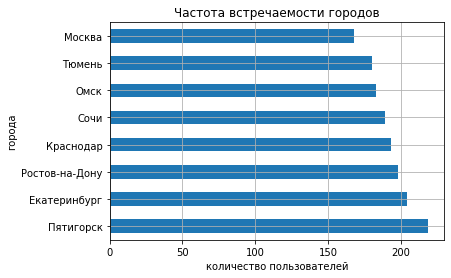

In [22]:
data_users.value_counts('city').plot( kind='barh', grid = True) # визуализируем данные
plt.title('Частота встречаемости городов')
plt.xlabel('количество пользователей')
plt.ylabel('города')
plt.show()

Отметим, что сервис аренды самокатов GoFast работал 8 городах. Больше всего клиентов в Пятигорске (219 человек), меньше всего - в Москве (168 человек).

---
Возможно, такие результаты связаны с тем, что в каких-то городах удобнее передвигаться на самокате, чем, к примеру на автомобиле. Но наиболее вероятно, что основная причина заключается в наличии конкурентов - во многих городах существуют другие сервисы аренды самокатов, которые пользуются большей популярностью. Можно предположить, что, например, в Москве много таких сервисов и по каким-то причинам пользователи делают выбор не в пользу GoFast.

### Соотношение пользователей с подпиской и без подписки

Рассмотрим датафрейм data_users и параметр 'subscription_type' (тип подписки). 

Как нам известно, существует всего два типа подписки: 
* *free* - без подписки: абонентская плата отсутствует, стоимость одной минуты поездки — 8 руб, стоимость старта (начала поездки) — 50 руб
* *ultra* - c подпиской: абонентская плата — 199 руб в месяц, стоимость одной минуты поездки — 6 руб, стоимость старта — бесплатно

Выясним, каких пользователей больше, результаты также визуализируем.

In [23]:
data_users.value_counts('subscription_type')

subscription_type
free     835
ultra    699
dtype: int64

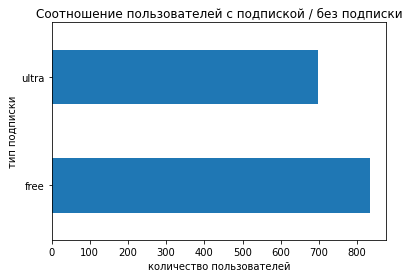

In [24]:
data_users.value_counts('subscription_type').plot(kind='barh')
plt.title('Соотношение пользователей с подпиской / без подписки')
plt.xlabel('количество пользователей')
plt.ylabel('тип подписки')
plt.show()

Посчитаем разбивку пользователей по тарифам в долях:

In [25]:
free = (len(data_users.query('subscription_type == "free"')) / len(data_users))
print('Доля пользователей с подпиской:', round(free, 2)) # доля пользователей без подписки

Доля пользователей с подпиской: 0.54


In [26]:
ultra = len(data_users.query('subscription_type == "ultra"')) / len(data_users) 
print('Доля пользователей с подпиской:', round(ultra, 2)) # доля пользователей с подпиской

Доля пользователей с подпиской: 0.46


---
Заметим, что любителей самокатов без подписки больше, чем с подпиской. Сервисом без подписки пользуются 54 % всех пользователей (835 человека), а с подпиской - 46 % (699 человек).

Безусловно, если часто пользоваться услугами сервиса, намного выгоднее приобрести подписку. Но, как правило, в любом сервисе (в любой сфере) количество бесплатных пользователей превышает количество платных. Сервис аренды самокатов GoFast - не исключение. Данные кажутся правдоподобными.

### Возраст пользователей

Рассмотрим датафрейм data_users и столбец 'age' (возраст). Проанализируем этот параметр. Данные представим на графике.

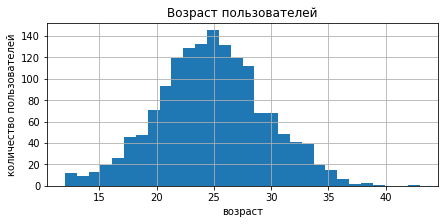

In [27]:
data_users['age'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, title='Возраст пользователей')
plt.xlabel('возраст')
plt.ylabel('количество пользователей')
plt.show()

In [28]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [29]:
data_users.value_counts('age').head(10)
# сервис наиболее популярен среди клиентов этих возрастов (возраст / количество клиентов этого возраста)

age
25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
dtype: int64

In [30]:
data_users.value_counts('age').tail(10)
# сервис наименее популярен среди клиентов этих возрастов (возраст / количество клиентов этого возраста)

age
35    15
15    13
14     9
13     8
36     6
12     4
38     3
37     2
39     1
43     1
dtype: int64

---
Как видим, наибольшей популярностью аренда самокатов пользуется у молодежи (22-28 лет), меньше всего любителей самокатов среднего возраста (37-43) и очень молодых (12-14). Средний возрат клиента сервиса GoFast - 25 лет, самый молодой клиент - 12 лет, самый взрослый - 43 года.

Распределение нормальное, данные кажутся реальными. Действительно, школьников на самокатах можно встретить нечасто. Большинство взрослых людей (35+) также предпочитают другой способ передвижения.

### Расстояние, которое пользователь преодолел за одну поездку

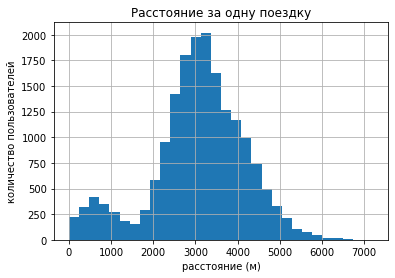

In [31]:
data_rides['distance'].plot(kind = 'hist', grid=True, bins = 30)
plt.title('Расстояние за одну поездку')
plt.xlabel('расстояние (м)')
plt.ylabel('количество пользователей')
plt.show()

In [32]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [33]:
data_rides['distance'].sort_values(ascending=False).head(10) # 10 самых длинных поездок (в метрах)

16309    7211.007745
16484    7066.003772
15580    6908.491343
17171    6760.940067
17242    6724.932981
10341    6671.969833
11385    6601.197575
12086    6538.937375
10915    6535.386520
11319    6503.600402
Name: distance, dtype: float64

In [34]:
data_rides['distance'].sort_values(ascending=False).tail(10) # 10 самых коротких поездок (в метрах)

11862    15.630873
15626    15.366168
13940    15.000606
8324     12.233115
8906     11.283615
7841      7.097072
8658      6.784447
13690     4.329506
9541      2.570787
11555     0.855683
Name: distance, dtype: float64

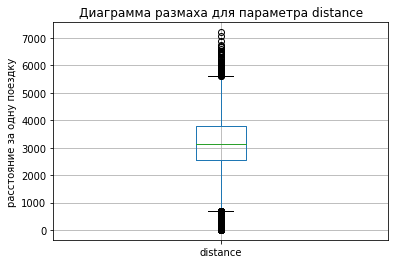

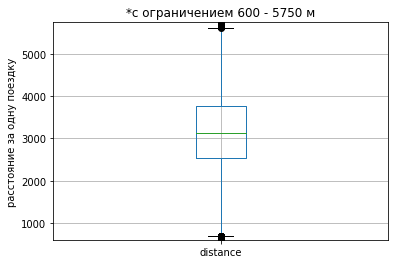

In [35]:
data_rides.boxplot(column='distance')
plt.title('Диаграмма размаха для параметра distance')
plt.ylabel('расстояние за одну поездку')
plt.show()

data_rides.boxplot(column='distance')
plt.title('*с ограничением 600 - 5750 м')
plt.ylabel('расстояние за одну поездку')
plt.ylim(600, 5750)
plt.show()

In [36]:
len(data_rides.query('distance < 600 or distance > 5750')) # сколько всего строк с выбросами

819

In [37]:
len(data_rides.query('distance < 600 or distance > 5750')) / len(data_rides) # доля строк с выбросами от всего датафрейма

0.04532875802523799

In [38]:
len(data_rides.query('distance < 10')) # сколько всего строк с расстоянием до 10 м

5

In [39]:
len(data_rides.query('distance < 10')) / len(data_rides) # доля строк с с расстоянием до 10 м от всего датафрейма

0.0002767323444764224

---
Распределение нормальное, в целом данные кажутся реальными. Среднее расстояние большинства поездок немного превышает 3 км (среднее - 3070 м, медианное - 3133 м). Максимальное расстояние, на которое клиент совершил поездку - 7211,01 м. Минимальное расстояние - 0.86 (клиент не проехал ни метра). 

Можно предположить, что такие слишком короткие поездки (на расстояние в несколько метров) связаны с тем, что клиент уже начал поездку, но по каким-то причинам передумал / отменил (это могут быть личные причины или неисправность самоката). Также не исключена вероятность технического сбоя программного обеспечения, в результате чего данные о поездке были зафиксированы неверно.

На гистограмме можно заметить небольшой всплеск около расстояния на 600 м - возможно, пользователи совершали такие короткие поездки, чтобы добраться до метро, парковок или остановок транспорта.

Благодаря диаграмме размаха удалось выяснить, что поездки на расстояние меньше 600 м и свыше 5750 м является выбросами (819 строк, что составляет 5 % от всего датафрейма data_rides). Как вариант, можно исключить из рассмотрения не все выбросы, а только самые короткие поездки, где очевидно, что фактически поездки не было. Например, поездки на расстояние до 10 м (31 строка, что составляет 0 % от всего датафрейма data_rides).

*На текущий момент строки с выбросами не удаляю, данную информацию зафиксирую как рекомендацию.*

### Продолжительность поездок

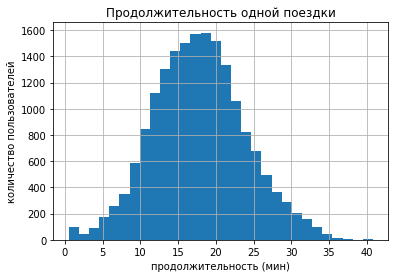

In [40]:
data_rides['duration'].plot(kind = 'hist', grid=True, bins = 30)
plt.title('Продолжительность одной поездки')
plt.xlabel('продолжительность (мин)')
plt.ylabel('количество пользователей')
plt.show()

In [41]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [42]:
data_rides['duration'].sort_values(ascending=False).head(10) # 10 самых долгих поездок (в минутах)

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
143     38.125729
3729    37.014141
499     36.906491
6348    36.809310
4653    36.622595
Name: duration, dtype: float64

In [43]:
data_rides['duration'].sort_values(ascending=False).tail(10) # 10 самых быстрых поездок (в минутах)

6531     0.5
16540    0.5
10650    0.5
11445    0.5
6570     0.5
6768     0.5
7883     0.5
16179    0.5
9497     0.5
16704    0.5
Name: duration, dtype: float64

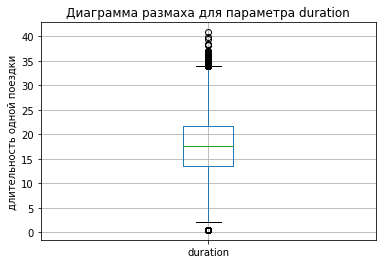

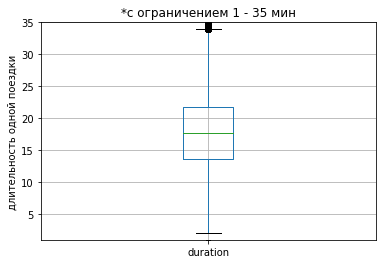

In [44]:
data_rides.boxplot(column='duration')
plt.title('Диаграмма размаха для параметра duration')
plt.ylabel('длительность одной поездки')
plt.show()

data_rides.boxplot(column='duration')
plt.title('*с ограничением 1 - 35 мин')
plt.ylabel('длительность одной поездки')
plt.ylim(1, 35)
plt.show()

In [45]:
len(data_rides.query('duration < 1 or duration > 35'))

123

In [46]:
len(data_rides.query('duration < 1 or duration > 35')) / len(data_rides)

0.006807615674119991

---
Распределение нормальное, в целом данные кажутся реалистичными.

Среднее время большинства поездок достигает почти 18 мин (среднее значение - 17.81 мин, медианное - 17.68 мин). Самая долгая поездка - 40.82 мин. Самая короткая - 0.5 мин. 

Вероятно, такие неправдоподобно быстрые поездки - это те короткие поездки, которые мы рассматривали ранее. Возможные причины такой длительности поездок аналогичные: клиент по личным или техническим причинам отменил поездку, сбой ПО и некорректная запись информации о поездке.

Благодаря диаграмме размаха удалось выяснить, что поездки длительностью меньше 1 мин и свыше 35 мин является выбросами (123 строки, что составляет 0.1 % от всего датафрейма data_rides). Эти строки можно удалить из дальнейшего рассмотрения.

*На текущий момент строки с выбросами не удаляю, данную информацию зафиксирую как рекомендацию.*

---
**Вывод:**

Cервис аренды самокатов GoFast работал 8 городах. Больше всего клиентов в Пятигорске (219 человек), меньше всего - в Москве (168 человек). Можно предположить, что такие результаты в некоторых городах связаны с наличием конкурентов, которые пользуются большей популярностью, чем GoFast.

Большинство любителей самокатов не приобретают подписку: 835 клиентов сервиса без подписки, с подпиской только 699. Эти данные кажутся правдоподобными, поскольку практически в любом сервисе количество бесплатных пользователей превышает платных.
  
Наибольшей популярностью аренда самокатов пользуется у молодежи, cредний возрат клиента сервиса GoFast - 25 лет. Самому взрослому клиенту - 43 года, а самому молодому всего 12 лет. Распределение нормальное, данные кажутся реалистичными. 
 
Также мы рассмотрели расстояние, которое пользователь преодолел за одну поездку. Распределение нормальное, данные кажутся реальными. На гистограмме есть небольшой всплеск около расстояния 600 м - возможно, пользователи совершали такие короткие поездки, чтобы добраться до метро, парковок или остановок транспорта. Среднее расстояние большинства поездок немного превышает 3 км. Максимальное расстояние - 7211,01 м, а минимальное - 0.86 (клиент не проехал ни метра). 

Была проанализирована продолжительность поездок. Распределение нормальное, данные выглядят правдоподобно. Среднее время большинства поездок достигает почти 18 мин. Самая долгая поездка - 40.82 мин, а самая короткая - 0.5 мин (фактически поездки не было).

Можно предположить, что такие слишком короткие и слишком быстрые поездки (расстояние в несколько метров и длительностью меньше минуты) связаны с тем, что клиент передумал / отменил поездку (по личным или техническим причинам). Также не исключена вероятность сбоя ПО и некорректной записи информации о поездке.

Благодаря диаграммам размаха удалось обнаружить выбросы - это поездки на расстояние меньше 600 м и свыше 5750 (819 строк - 5 % от всего датафрейма) и поездки длительностью меньше 1 мин и свыше 35 мин (123 строки - 0.1 % от всего датафрейма). Эти строки можно исключить из дальнейшего рассмотрения. Как вариант, можно исключить из рассмотрения не все поездки меньше 600 м и свыше 5750, а только самые короткие поездки, на расстояние до 10 м, где поездка явно не случилась (таких данных всего 31 строка, что составляет 0 % от всего датафрейма).

*На текущий момент строки с выбросами не удаляю, данную информацию зафиксирую как рекомендацию.*

## Шаг 4. Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датафрейм с помощью метода merge()

In [47]:
data_users.columns

Index(['index', 'user_id', 'name', 'age', 'city', 'subscription_type'], dtype='object')

In [48]:
data_rides.columns

Index(['index', 'user_id', 'distance', 'duration', 'date', 'month'], dtype='object')

In [49]:
data_subscriptions.columns

Index(['subscription_type', 'minute_price', 'start_ride_price',
       'subscription_fee'],
      dtype='object')

In [50]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              1534 non-null   int64 
 1   user_id            1534 non-null   int64 
 2   name               1534 non-null   object
 3   age                1534 non-null   int64 
 4   city               1534 non-null   object
 5   subscription_type  1534 non-null   object
dtypes: int64(3), object(3)
memory usage: 72.0+ KB


In [51]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     18068 non-null  int64         
 1   user_id   18068 non-null  int64         
 2   distance  18068 non-null  float64       
 3   duration  18068 non-null  float64       
 4   date      18068 non-null  datetime64[ns]
 5   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 847.1 KB


In [52]:
general_data = data_users.merge(data_rides, on='user_id')
# объединили датафреймы data_users и data_rides в один датафрейм general_data по столбцу 'user_id'
general_data = general_data.merge(data_subscriptions, on='subscription_type')
# объединили новый датафрейм general_data и data_subscriptions по столбцу 'subscription_type'
general_data

,index_x,user_id,name,age,city,subscription_type,index_y,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,0,4409.919140,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,1,2617.592153,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,2,754.159807,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,3,2694.783254,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1533,1534,Альберт,25,Краснодар,free,18063,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1533,1534,Альберт,25,Краснодар,free,18064,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1533,1534,Альберт,25,Краснодар,free,18065,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1533,1534,Альберт,25,Краснодар,free,18066,2902.308661,16.674362,2021-11-27,11,8,50,0


In [53]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index_x            18068 non-null  int64         
 1   user_id            18068 non-null  int64         
 2   name               18068 non-null  object        
 3   age                18068 non-null  int64         
 4   city               18068 non-null  object        
 5   subscription_type  18068 non-null  object        
 6   index_y            18068 non-null  int64         
 7   distance           18068 non-null  float64       
 8   duration           18068 non-null  float64       
 9   date               18068 non-null  datetime64[ns]
 10  month              18068 non-null  int64         
 11  minute_price       18068 non-null  int64         
 12  start_ride_price   18068 non-null  int64         
 13  subscription_fee   18068 non-null  int64         
dtypes: dat

In [54]:
general_data['user_id'].nunique()

1534

До объединения данных в таблицах было представлено 1534 пользователя, общее количество поездок, которые они совершили — 18068.

После объединения в общей таблице general_data содержится 18068 записей о поездках 1534 пользователей. Пропусков в полученном датафрейме нет.

### Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1: c данными о пользователях без подписки; с данными о пользователях с подпиской

In [55]:
without_subscription = general_data.query('subscription_type == "free"') # с данными о пользователях без подписки
without_subscription.head()

,index_x,user_id,name,age,city,subscription_type,index_y,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,699,700,Айдар,22,Омск,free,6500,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,699,700,Айдар,22,Омск,free,6501,846.932642,16.234663,2021-02-01,2,8,50,0
6502,699,700,Айдар,22,Омск,free,6502,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,699,700,Айдар,22,Омск,free,6503,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,699,700,Айдар,22,Омск,free,6504,3047.379435,17.427673,2021-02-14,2,8,50,0


In [56]:
with_subscription = general_data.query('subscription_type == "ultra"') # с данными о пользователях с подпиской
with_subscription.head()

,index_x,user_id,name,age,city,subscription_type,index_y,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,0,4409.919140,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,1,2617.592153,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,2,754.159807,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,3,2694.783254,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4,4028.687306,26.265803,2021-08-28,8,6,0,199


In [57]:
len(without_subscription) + len(with_subscription)

18068

In [58]:
len(general_data)

18068

In [59]:
without_subscription['subscription_type'].nunique()

1

In [60]:
with_subscription['subscription_type'].nunique()

1

In [61]:
without_subscription.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index_x            11568 non-null  int64         
 1   user_id            11568 non-null  int64         
 2   name               11568 non-null  object        
 3   age                11568 non-null  int64         
 4   city               11568 non-null  object        
 5   subscription_type  11568 non-null  object        
 6   index_y            11568 non-null  int64         
 7   distance           11568 non-null  float64       
 8   duration           11568 non-null  float64       
 9   date               11568 non-null  datetime64[ns]
 10  month              11568 non-null  int64         
 11  minute_price       11568 non-null  int64         
 12  start_ride_price   11568 non-null  int64         
 13  subscription_fee   11568 non-null  int64         
dtypes: 

In [62]:
with_subscription.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index_x            6500 non-null   int64         
 1   user_id            6500 non-null   int64         
 2   name               6500 non-null   object        
 3   age                6500 non-null   int64         
 4   city               6500 non-null   object        
 5   subscription_type  6500 non-null   object        
 6   index_y            6500 non-null   int64         
 7   distance           6500 non-null   float64       
 8   duration           6500 non-null   float64       
 9   date               6500 non-null   datetime64[ns]
 10  month              6500 non-null   int64         
 11  minute_price       6500 non-null   int64         
 12  start_ride_price   6500 non-null   int64         
 13  subscription_fee   6500 non-null   int64         
dtypes: datet

In [63]:
without_subscription.describe()

,index_x,user_id,age,index_y,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1119.527230,1120.527230,24.893326,12283.500000,3045.495282,17.390909,6.522994,8.0,50.0,0.0
std,241.165628,241.165628,4.481100,3339.538291,1246.173806,6.326803,3.449770,0.0,0.0,0.0
min,699.000000,700.000000,12.000000,6500.000000,0.855683,0.500000,1.000000,8.0,50.0,0.0
25%,914.000000,915.000000,22.000000,9391.750000,2366.562689,12.958437,4.000000,8.0,50.0,0.0
50%,1122.000000,1123.000000,25.000000,12283.500000,3114.648465,17.326890,7.000000,8.0,50.0,0.0
75%,1327.000000,1328.000000,28.000000,15175.250000,3905.697894,21.594071,9.000000,8.0,50.0,0.0
max,1533.000000,1534.000000,43.000000,18067.000000,7211.007745,34.948498,12.000000,8.0,50.0,0.0


In [64]:
with_subscription.describe()

,index_x,user_id,age,index_y,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,347.725385,348.725385,24.892615,3249.500000,3115.445388,18.541985,6.422308,6.0,0.0,199.0
std,201.099339,201.099339,4.757208,1876.532707,836.895330,5.572048,3.414616,0.0,0.0,0.0
min,0.000000,1.000000,12.000000,0.000000,244.210438,3.760353,1.000000,6.0,0.0,199.0
25%,174.000000,175.000000,22.000000,1624.750000,2785.444017,14.524654,4.000000,6.0,0.0,199.0
50%,350.000000,351.000000,25.000000,3249.500000,3148.637229,18.178153,6.000000,6.0,0.0,199.0
75%,524.000000,525.000000,28.000000,4874.250000,3560.574425,21.884129,9.000000,6.0,0.0,199.0
max,698.000000,699.000000,38.000000,6499.000000,5699.769662,40.823963,12.000000,6.0,0.0,199.0


Итак, в результате получили две таблицы: without_subscription (все поездки с данными о пользователях без подписки), with_subscription (все поездки с данными о пользователях c подпиской). 

Датафрейм without_subscription содержит 11568 строк, with_subscription - 6500 строк. Общая сумма стров в обоих таблицах 18068, как и было до разделения таблицы general_data.
Пропусков в новых таблицах нет.

### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

* Визуализируем параметр 'distance' (расстояние одной поездки) для пользователей с подпиской и без:

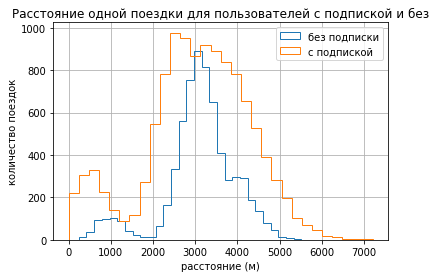

In [65]:
ax = with_subscription['distance'].plot(kind = 'hist', grid=True, histtype =  'step', bins = 30, label='без подписки')
ax = without_subscription['distance'].plot(kind = 'hist', grid=True, histtype =  'step', bins = 30, label='с подпиской')
plt.title('Расстояние одной поездки для пользователей с подпиской и без')
plt.xlabel('расстояние (м)')
plt.ylabel('количество поездок')
plt.legend(loc='upper right')
plt.show()

<div class="alert alert-block alert-success">

**Комментарий ревьювера (все отлично)**
    
Отличное решение совместить два распределения на одном графике👍
</div>

* Визуализируем параметр 'duration' (продолжительность одной поездки) для пользователей с подпиской и без:

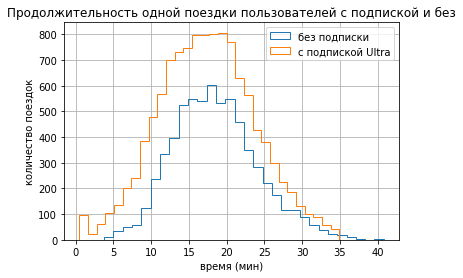

In [66]:
ax = with_subscription['duration'].plot(kind = 'hist', grid=True, histtype =  'step', bins = 30, label='без подписки')
ax = without_subscription['duration'].plot(kind = 'hist', grid=True, histtype =  'step', bins = 30, label='с подпиской Ultra')
plt.title('Продолжительность одной поездки пользователей с подпиской и без')
plt.xlabel('время (мин)')
plt.ylabel('количество поездок')
plt.legend(loc='upper right')
plt.show()

---
Итак, три исходных датафрейма: data_users (с данными о пользователях), data_rides (с данными о поездках) и data_subscriptions (с информацией о подписках) объединили в один датафрейм general_data с помощью метода merge().

На основе полученного датафрейма были созданые ещё два: without_subscription (все поездки с данными о пользователях без подписки), with_subscription (все поездки с данными о пользователях c подпиской).

Сравним данные по поездкам с подпиской и без (*отметим, что на текущий момент из рассмотрения еще не исключили выбросы - слишком быстрые и слишком короткие поездки*):  
* Поездок без подписки на 5068 больше, чем с подпиской  
* Возрастные показатели пользователей с разным типом подписки в целом схожи, за исключением максимального возраста, который выше у пользователей без подписки на 5 лет
* Дистанция поездок без подписки более разнообразна, о чем говорит стандартное отклонение, которое без подписки больше на 409 м Максимальная дистанция без подписки больше на 1511 м, а средняя дистанция на 70 м короче, чем с подпиской 
* Продолжительность поездок без подписки по всем показателям меньше, чем с подпиской
* Сезонность использования разного типа подписки схожа за исключением медианы, которая у пользователей с подпиской ultra приходится на июнь, а у пользователей без подписки - на июль

## Шаг 5. Подсчёт выручки 

### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа: например, значения 25.3, 25.5, 26.0 будут преобразованы к 26. 

Операцию выполним с помощью метода «потолок» библиотеки numpy — np.ceil() и приведем к типу int:

In [67]:
general_data['duration'] = np.ceil(general_data['duration'])
general_data['duration'] = general_data['duration'].astype('int')

In [68]:
general_data_agg = general_data.pivot_table(index= ['user_id', 'month'], values = ['distance', 'duration'], aggfunc = ['count', 'sum'])
general_data_agg.columns = ['count_riders', 'count_riders_double', 'sum_distance', 'sum_duration'] # переименуем столбцы
general_data_agg = general_data_agg.drop(columns=['count_riders_double']) # удалим лишний столбец с числом поездок
general_data_agg = general_data_agg.reset_index()
general_data_agg.head()

,user_id,month,count_riders,sum_distance,sum_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56


Итак, мы создали новый датафрейм general_data_agg с агрегированными данными о поездках на основе датафрейма с объединёнными данными general_data. 

В таблице 3 столбца, которые отображают следующую информацию: 
* **'count_riders'** - общее количество поездок для каждого пользователя за каждый месяц
* **'sum_distance'** - суммарное расстояниевсех поездок для каждого пользователя за каждый месяц
* **'sum_duration'** - суммарное время поездок для каждого пользователя за каждый месяц

### В полученный датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь

Для этого обратимся к информации об условиях оплаты для пользователей с подпиской и без. Продолжительность каждой поездки уже округлили ранее.

В датафрейм general_data_agg добавим столбец 'subscription_type' c информацией о типе подписки для каждого пользователя, для чего с помощью метода merge() объединим датафреймы general_data_agg и data_users и удалим лишние столбцы. 

In [69]:
general_data_agg = general_data_agg.merge(data_users, on='user_id')
#general_data_agg = general_data_agg.drop(columns=['index', 'name', 'age', 'city'])
general_data_agg = general_data_agg.drop(columns=['index','name', 'age', 'city'])
general_data_agg.head()

,user_id,month,count_riders,sum_distance,sum_duration,subscription_type
0,1,1,2,7027.511294,42,ultra
1,1,4,1,754.159807,7,ultra
2,1,8,2,6723.470560,46,ultra
3,1,10,2,5809.911100,32,ultra
4,1,11,3,7003.499363,56,ultra


Далее необходимо поместить в датафрейм информацию о подписке - добавим столбцы 'minute_price', 'start_ride_price', 'subscription_fee'. Аналогично с помощью метода merge() объединим general_data_agg и data_subscriptions:

In [70]:
general_data_agg = general_data_agg.merge(data_subscriptions, on='subscription_type')
general_data_agg.head()

,user_id,month,count_riders,sum_distance,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42,ultra,6,0,199
1,1,4,1,754.159807,7,ultra,6,0,199
2,1,8,2,6723.470560,46,ultra,6,0,199
3,1,10,2,5809.911100,32,ultra,6,0,199
4,1,11,3,7003.499363,56,ultra,6,0,199


К преобразованному датафрейму general_data_agg добавим новый столбец 'month_income', в котором рассчитаем помесячную выручку для каждого пользователя.

Расчет будем производить по следующей формуле:  
**помесячная выручка  = стоимость старта поездки * количество поездок + стоимость одной минуты поездки * общая продолжительность всех поездок в минутах + стоимость подписки**

In [71]:
general_data_agg['month_income'] = general_data_agg['start_ride_price'] * general_data_agg['count_riders'] + \
general_data_agg['minute_price'] * general_data_agg['sum_duration'] + general_data_agg['subscription_fee']
general_data_agg.head()

,user_id,month,count_riders,sum_distance,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,month_income
0,1,1,2,7027.511294,42,ultra,6,0,199,451
1,1,4,1,754.159807,7,ultra,6,0,199,241
2,1,8,2,6723.470560,46,ultra,6,0,199,475
3,1,10,2,5809.911100,32,ultra,6,0,199,391
4,1,11,3,7003.499363,56,ultra,6,0,199,535


На этом этапе создадим еще два датафрейма, которые нам потребуются в дальнейшем для проверки гипотез в пункте 6.3:
* **without_subscription_income** - данные о пользователе без подписки с информацией о помесячном доходе
* **with_subscription_income** - данные о пользователе с подпиской с информацией о помесячном доходе

In [72]:
without_subscription_income = general_data_agg.query('subscription_type == "free"')
without_subscription_income.head()

,user_id,month,count_riders,sum_distance,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,month_income
4533,700,1,1,2515.690719,15,free,8,50,0,170
4534,700,2,5,13446.659764,89,free,8,50,0,962
4535,700,3,1,3798.334905,19,free,8,50,0,202
4536,700,4,1,2984.551206,16,free,8,50,0,178
4537,700,6,2,5927.650988,29,free,8,50,0,332


In [73]:
with_subscription_income = general_data_agg.query('subscription_type == "ultra"')
with_subscription_income.head()

,user_id,month,count_riders,sum_distance,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,month_income
0,1,1,2,7027.511294,42,ultra,6,0,199,451
1,1,4,1,754.159807,7,ultra,6,0,199,241
2,1,8,2,6723.470560,46,ultra,6,0,199,475
3,1,10,2,5809.911100,32,ultra,6,0,199,391
4,1,11,3,7003.499363,56,ultra,6,0,199,535


Из датарфейма general_data_agg удалим вспомогательные столбцы , которые мы использовали для расчета помесячной выручки:

In [74]:
general_data_agg = general_data_agg.drop(columns=['subscription_type','minute_price', 'start_ride_price', 'subscription_fee'])
general_data_agg.head()

,user_id,month,count_riders,sum_distance,sum_duration,month_income
0,1,1,2,7027.511294,42,451
1,1,4,1,754.159807,7,241
2,1,8,2,6723.470560,46,475
3,1,10,2,5809.911100,32,391
4,1,11,3,7003.499363,56,535


---
Итак, был создан датафрейм general_data_agg с агрегированными данными о поездках на основе датафрейма general_data. Были найдены следующие параметры: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц (столбцы 'sum_distance', 'count_riders' и 'sum_duration' соответственно).

Также был добавлен столбец 'month_income' с помесячной выручкой, которую принёс каждый пользователь. 

## Шаг 6. Проверка гипотез 

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

Для этого проверим следующие гипотезы:

### Гипотеза 1

**Важно понять, тратят ли пользователи с подпиской больше времени на поездки? 
Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.**


Сравним две выборки: with_subscription (пользователи с подпиской), without_subscription (пользователи без подписки).

Будем проверять следующие гипотезы:
* нулевая гипотеза - среднее время поездок пользователей с подпиской и пользователей без подписки равны
* альтернативная гипотеза - среднее время поездок пользователей с подпиской больше, чем пользователей без подписки (пользователи с подпиской тратят больше времени на поездки)

Будем использовать метод ttest_ind(), которому передадим параметр alternative='greater'.

In [75]:
alpha = 0.05 # задаём уровень значимости
results = st.ttest_ind(with_subscription['duration'], without_subscription['duration'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута в пользу альтернативной.

Проведем проверку:

In [76]:
with_subscription['duration'].mean().round(2) # среднее время поездки пользователей с подпиской

18.54

In [77]:
without_subscription['duration'].mean().round(2) # среднее время поездки пользователей без подписки

17.39

Пользователи с подпиской действительно тратят больше времени на поездки, чем пользователи без подписки.

### Гипотеза 2

**Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.**

Рассмотрим выборку пользователей с подпиской with_subscription.

Будем проверять следующие гипотезы:

* нулевая гипотеза - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м (не превышает 3130 м)
* альтернативная гипотеза - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м

Будем использовать метод ttest_1samp, которому передадим параметр alternative='greater'.

In [78]:
optimal_distance = 3130 # оптимальное расстояние с точки зрения износа самоката
alpha = 0.05 # задаём уровень значимости
results = st.ttest_1samp(with_subscription['distance'], optimal_distance, alternative='greater')

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Проведем проверку и найдем среднее расстояние, которое проезжают пользователи с подпиской за одну поездку,:

In [79]:
with_subscription['distance'].mean().round(2)

3115.45

Таким образом, нулевую гипотезу отвергнуть мы не можем. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Действительно, полученное при поверке значение (3115.45 м) находится довольно близко от оптимального.

### Гипотеза 3

**Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.**

Для анализа будем рассматривать датафреймы without_subscription_income и with_subscription_income, которые были созданы ранее в пуекте 5.2:

* **without_subscription_income** - данные о пользователе без подписки с информацией о помесячном доходе
* **with_subscription_income** - данные о пользователе с подпиской с информацией о помесячном доходе

Будем проверять следующие гипотезы:

* нулевая гипотеза - помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки
* альтернативная гипотеза - помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Будем использовать метод ttest_ind(), которому передадим параметр alternative='greater'.

In [80]:
alpha = 0.05 # задаём уровень значимости
results = st.ttest_ind(with_subscription_income['month_income'], without_subscription_income['month_income'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута в пользу альтернативной.

Проведем проверку:

In [81]:
with_subscription_income['month_income'].mean().round(2)

362.79

In [82]:
without_subscription_income['month_income'].mean().round(2)

328.64

Помесячная выручка от пользователей с подпиской действительно выше, чем выручка от пользователей без подписки.

### Гипотеза 4

**Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Сначала необходимо провести сравнение выборок на предмет соответствия уникальных пользователей в них. 

*Если списки уникальных пользователей в них совпадают, то выборки зависимы (или парные)*. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов, при этом порядок объектов в обоих массивах одинаковый: k-е по порядку число в первом наборе и k-е число во втором наборе — это измерения для одного и того же объекта до и после изменения. В нашем примере это пара измерений для каждого пользователя — до и после обновления. 

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок потребуется тест **st.ttest_rel(after, before, alternative=’less’)**, которому передадим три параметра: набор данных после обновления, набор данных до обновления и параметр alternative=’less’.

Параметр alternative='less' нужно указать для того, чтобы проверить левостороннюю альтернативную гипотезу о том, что обращений после обновления сервиса стало меньше, чем до обновления (нулевая гипотеза в этом случае будет о равенстве количества обращений в техподдержку до и после обновления).

*Если списки уникальных пользователей не совпадают, выборки не могут быть зависимы*, то для проверки гипотезы потребуется тест **st.ttest_ind(after, before, equal_var=False, alternative=’less’)**, которому на входе передадим четыре параметра: набор данных после обновления, набор данных до обновления и параметры equal_var=False, alternative=’less’.

Параметр equal_var=False укажем, предполагая, что рассматриваемые выборки разного размера и/или у генеральных совокупностей разные дисперсии.

---
Итак, мы проверили несколько гипотез и готовы предоставить продакт-менеджерам сервиса результаты исследования.

* **Тратят ли пользователи с подпиской больше времени на поездки?**

H0: среднее время поездок пользователей с подпиской и пользователей без подписки равны  
H1: среднее время поездок пользователей с подпиской больше, чем пользователей без подписки.  
Для анализа использовали метод ttest_ind() c параметром alternative='greater'.  

Нулевая гипотеза отвергнута в пользу альтернативной. Пользователи с подпиской действительно тратят больше времени в поездки, чем пользователи без подписки. 

* **Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м? (расстояние 3130 м - оптимальное с точки зрения износа самоката)**

H0: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м (не превышает 3130 м)   
H1: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м  
Для анализа использовался метод ttest_1samp c параметром alternative='greater'  

Не получилось отвергнуть нулевую гипотезу. Действительно, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

* **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**

Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

H0: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки  
H1: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки  
Для анализа использовался метод ttest_ind() c параметром alternative='greater'.

Нулевая гипотеза отвергнута в пользу альтернативной. Помесячная выручка от пользователей с подпиской действительно выше, чем выручка от пользователей без подписки. Это говорит о том, что модель подписки с учетом месячной платы приносит дополнительный доход компании. 

---
Результаты исследования позволяют сделать вывод о том, что пользователи с подпиской более выгодны для компании (более активно используют сервис, приносят больше помесячной выручки). Таким образом, рекомендуем продвигать подписки и стимулировать пользователей к долгосрочному использованию сервиса. 

* **Какой тест потребуется для провереки гипотезы о том, что после обновления серверов количество обращений в техподдержку значимо снизилось? (данные о количестве обращений в техподдержку до обновления и после него для каждого пользователя содержатся в некотором файле)**

Сначала необходимо провести сравнение выборок на предмет соответствия уникальных пользователей в них.

Если списки уникальных пользователей в них совпадают, то выборки зависимые (или парные), и в этом случае потребуется тест st.ttest_rel(after, before, alternative=’less’).

Если выборки не зависят друг от друга, то для проверки гипотезы потребуется тест st.ttest_ind(after, before, equal_var=False, alternative=’less’).

## Шаг 7. Распределения

### Кейс 1

**Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов**

Так как в данном эксперименте есть только два исхода (продление / не продление подписки), обратимся к биноминальному распределению.

Известно, что после бесплатного пробного периода подписку продлевают 10 % пользователей, таким образом p=0.1

Вероятность не выполнить план -  5 %, таким образом вероятность выполнить план - 95 %.

Предположим, что минимум 100 клиентов, которые должны купить подписку, это 10 % от количества всех клиентов, кому был отправлен промокод. Таким образом, k=100 будем использовать как отправную точку, от которой начнем подбор значений.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


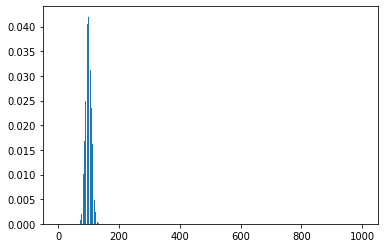

In [83]:
# построим график биномиального распределения
p = 0.1 
n = 1000

distr = [] 

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr) 
plt.show()

In [84]:
t = 0
list = []

while (1 - binom.cdf(k=99, n=t , p=0.1)) <= 0.95:
    t += 1
    list.append(t)
 
print("Минимальное число промокодов:", len(list))    

Минимальное число промокодов: 1161


---
Итак, чтобы вероятность не выполнить план была примерно 5 %, требуется разослать клиентам минимум 1161 промокод.

### Кейс 2

**Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей**

Так как в данном эксперименте есть только два исхода (клиент открыл / не открыл push-уведомление), можно говорить о биноминальном распределении.

Для решения задачи будем проводить аппроксимацию биномиального распределения нормальным. Зададим математическое ожидание и стандартное отклонение нормального распределения равными математическому ожиданию и стандартному отклонению биномиального распределения.
    
Параметры биноминального распределения:  
n - количество экспериментов (1 млн)  
p - вероятность успеха (40 %)  
x - заданное значение, для которого расчитывается вероятность (399,5 тыс)

In [85]:
n = 1000000
p = 0.4
x = 399500

# рассчитаем параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# зададим нормальное распределение
distr = st.norm(mu, sigma)

# рассчитаем вероятность, что случайная величина (откроют уведомление) примет значение, меньшее заданного аргумента (399500)
result = distr.cdf(x)
print('Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей:', round(result, 5))

Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей: 0.15372


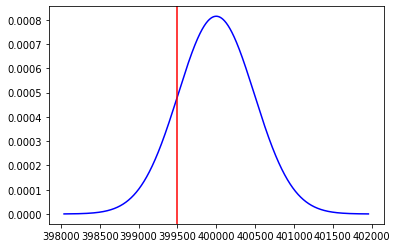

In [86]:
# построим график

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
arange = np.arange((mu - 4 * sigma), (mu + 4 * sigma), 1)
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.axvline(x=x, color='red')
plt.show()

---
Таким образом, если отдел разошлет 1 млн. уведомлений, то вероятность того, что их откроет не более 399.5 тыс. пользователей, равна 15.37%.

## Шаг 8. Выводы

**Цель исследования** - в результате анализа данных проверить некоторые гипотезы, которые мешают бизнесу вырасти.

**Данные для анализа** – информация о пользователях сервиса аренды самокатов Go Fast, их поездках и подписках.

### Загрузка данных

Считали CSV-файлы, данные сохранили в датафреймы data_users (информация о пользователях), data_rides (информация о поездках), data_subscriptions (информация о подписках). Пропусков в данных обнаружено не было.

### Предобработка данных
Подготовили данные к дальнейшему анализу:
* провели работу с некорректными типами данных (в датафрейме data_rides в столбце 'date' изменили тип с object на datetime)
* в датафрейме data_rides добавили новый столбец 'month' с номером месяца на основе столбца 'date'
* провели работу с дубликатами (устранили 31 дубликат в выборке с информацей о пользователях data_users).

### Исследовательский анализ данных

Описали и визуализировали общую информацию о пользователях и поездках:

**Частота встречаемости городов**  
Cервис аренды самокатов GoFast работал 8 городах. Больше всего пользователей в Пятигорске (219 человек), меньше всего - в Москве (168 человек). Мы предполагаем, что такие результаты связаны с наличием конкурентов в некоторых городах, которые пользуются большей популярностью, чем GoFast.
	
**Соотношение пользователей с подпиской и без подписки**  
Большинство любителей самокатов не приобретают подписку: 835 клиентов сервиса без подписки, с подпиской только 699. Эти данные кажутся правдоподобными, поскольку чаще всего пользователи предпочитают бесплатные версии сервисов, тарифы без абонентской платы (в любой сфере).

**Возраст пользователей**  
Наибольшей популярностью сервис пользуется у молодежи, cредний возрат клиента сервиса GoFast - 25 лет. Самому взрослому клиенту - 43 года, а самому молодому всего 12 лет. Распределение нормальное, данные кажутся реалистичными.

**Расстояние, которое пользователь преодолел за одну поездку**  
Распределение нормальное, данные кажутся реальными. Есть небольшой всплеск около расстояния 600 м - возможно, пользователи совершали такие короткие поездки, чтобы добраться до станций метро, парковок или остановок транспорта. Среднее расстояние большинства поездок немного превышает 3 км. Максимальное расстояние - 7211,01 м, а минимальное - 0.86 (клиент не проехал ни метра).

**Продолжительность поездок**
Была проанализирована продолжительность поездок. Распределение нормальное, данные кажутся правдоподобными. Среднее время большинства поездок достигает почти 18 мин. Самая долгая поездка - 40.82 мин, а самая короткая - 0.5 мин (фактически поездки не было).

Можно предположить, что такие слишком короткие и слишком быстрые поездки (расстояние в несколько метров и длительностью меньше минуты) связаны с тем, что клиент передумал / отменил поездку (по личным или техническим причинам). Также не исключена вероятность сбоя ПО и некорректной записи информации о поездке.

В данных были обнаружены выбросы - поездки на расстояние меньше 600 м и свыше 5750, поездки длительностью меньше 1 мин и свыше 35 мин (суммарно 942 строки - 5 % от всего датафрейма data_rides). Эти строки можно исключить из дальнейшего рассмотрения. Как вариант, можно исключить из рассмотрения не все поездки меньше 600 м и свыше 5750, а только самые короткие поездки, на расстояние до 10 м, где поездка явно не случилась (таких данных всего 31 строка, что составляет 0 % от всего датафрейма). *На текущий момент строки с выбросами не удаляю, данную информацию зафиксирую как рекомендацию.*

### Объединение данных

Три исходных датафрейма объединили в один датафрейм general_data с помощью метода merge().
На основе полученного датафрейма были созданые ещё два: without_subscription (все поездки с данными о пользователях без подписки); with_subscription (все поездки с данными о пользователях c подпиской).

Сравним данные по поездкам с подпиской и без (*отметим, что на текущий момент из рассмотрения еще не исключили выбросы*):  
* Поездок без подписки на 5068 больше, чем с подпиской
* Возрастные показатели пользователей с разным типом подписки в целом схожи, за исключением максимального возраста, который на 5 лет больше у пользователей без подписки
* Дистанция поездок без подписки более разнообразна, о чем говорит стандартное отклонение, которое без подписки больше на 409 м Максимальная дистанция без подписки больше на 1511 м, а средняя дистанция на 70 м короче, чем с подпиской
* Продолжительность поездок без подписки по всем показателям меньше, чем с подпиской
* Сезонность использования разного типа подписки схожа за исключением медианы, которая у пользователей с подпиской ultra приходится на июнь, а у пользователей без подписки - на июль.

### Подсчёт выручки

Был создан датафрейм general_data_agg с агрегированными данными о поездках на основе датафрейма general_data. Были найдены следующие параметры: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц (столбцы 'sum_distance', 'count_riders' и 'sum_duration' соответственно).
Также был добавлен столбец 'month_income' с помесячной выручкой, которую принёс каждый пользователь.

### Проверка гипотез

С помощью статистических методов были проверены следующие гипотезы:  

**Тратят ли пользователи с подпиской больше времени на поездки?**  
H0: среднее время поездок пользователей с подпиской и пользователей без подписки равны  
H1: среднее время поездок пользователей с подпиской больше, чем пользователей без подписки.  
Для анализа использовали метод ttest_ind() c параметром alternative='greater'.  
Нулевая гипотеза отвергнута в пользу альтернативной. Пользователи с подпиской действительно тратят больше времени в поездки, чем пользователи без подписки.

**Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м? (расстояние 3130 м - оптимальное с точки зрения износа самоката)**  
H0: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 м (не превышает 3130 м)
H1: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м
Для анализа использовался метод ttest_1samp c параметром alternative='greater'

Не получилось отвергнуть нулевую гипотезу. Действительно, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

**Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**  
Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.  
H0: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки  
H1: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки  
Для анализа использовался метод ttest_ind() c параметром alternative='greater'.  
Нулевая гипотеза отвергнута в пользу альтернативной. Помесячная выручка от пользователей с подпиской действительно выше, чем выручка от пользователей без подписки. Это говорит о том, что модель подписки с учетом месячной платы приносит дополнительный доход компании.

---
Результаты исследования позволяют сделать вывод о том, что пользователи с подпиской более выгодны для компании (более активно используют сервис, приносят больше помесячной выручки). Таким образом, рекомендуем продвигать подписки и стимулировать пользователей к долгосрочному использованию сервиса.

**Какой тест потребуется для провереки гипотезы о том, что после обновления серверов количество обращений в техподдержку значимо снизилось? (данные о количестве обращений в техподдержку до обновления и после него для каждого пользователя содержатся в некотором файле)**  
Сначала необходимо провести сравнение выборок на предмет соответствия уникальных пользователей в них.  
Если списки уникальных пользователей в них совпадают, то выборки зависимые (или парные), и в этом случае потребуется тест st.ttest_rel(after, before, alternative=’less’).  
Если выборки не являются зависимыми, то для проверки гипотезы потребуется тест st.ttest_ind(after, before, equal_var=False, alternative=’less’).

### Распределения

**Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов**

Чтобы вероятность не выполнить план была примерно 5 %, требуется разослать клиентам минимум 1161 промокод (график распределения построен).

**Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей**

Eсли разослать 1 млн. уведомлений, то вероятность того, что их откроет не более 399.5 тыс. пользователей, равна 15.37% (результаты визуализировали).

### Рекомендации

На основании результатов, полученных в ходе исследования, для развития бизнеса можно предложить следующее:

* продвигать подписки

Было выявлено, что пользователи с подпиской более выгодны для компании (более активно используют сервис, приносят больше помесячной выручки). Таким образом, рекомендуем продвигать подписки и стимулировать пользователей к долгосрочному использованию сервиса. Один из вариантов - разработать и внедрить систему бонусов и привилегий для подписчиков, также можно рассмотреть сезонные предложения, какие-либо акции на подписки.

* стимулировать клиентов к активному использованию сервиса

Пользователи, которые проводят большое количество времени в поездках, являются ценными для бизнеса. Как вариант, тем пользователям, которые активно используют сервис, можно предоставить скидки или бонусы.

* разработать новые тарифные планы

Разные группы пользователей при использовании сервиса имеют разные предпочтения и цели. Поэтому целесообразно будет разработать новые тарифные планы, которые будут удовлетворять потребности разных клиентов. Это позволить удержать старых клиентов и привлечь новых.

По всем обозначенным направлениям рекомендуем провести дополнительный анализ, для которого потребуются соответствующие данные.